In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import sys

In [2]:
'''
Color encoding
'''
# SETTING
pixel_max = 254 #Customerization

# CHANNEL 0: BASE
base_color_stride = 70 #Customerization
offset_a_g = 40 #Customerization
offset_t_c = 30 #Customerization

# CHANNEL 1: BASE QUALITY
default_quality = 0
base_quality_cap = 40

# CHANNEL 2: MAPPING QUALITY
mapping_set_empty = 255 #Customerization
mapping_quality_cap = 60 #Customerization

# CHANNEL 3: ON POSITIVE STRAND
set_empty = 255 #Customerization
positive_strand = 70 #Customerization
negative_strand = 240 #Customerization

# CHANNEL 4: MATCH REFERENCE
pixel_max = 254 #Customerization
not_match_ref = pixel_max * 1 #Customerization
match_ref = pixel_max * 0.2 #Customerization
ref_not_provided = 255 #Customerization

# TO RGB
pixel_max_empty_def = 255

#############################################################################################
# CHANNEL 1: Base quality

def base_to_color(x):
    A = base_color_stride * 3 + offset_a_g
    T = base_color_stride * 2 + offset_t_c
    C = base_color_stride * 1 + offset_t_c
    G = base_color_stride * 0 + offset_a_g
    if x == "A":
        return A
    elif x == "T":
        return T
    elif x == "C":
        return C
    elif x == "G":
        return G
    elif x == "N":
        return 0
    elif x == "D":
        return 0
    else:
        return 0

# CHANNEL 1: Base quality
Quality_Score_Encoding = {"!":0,"\"":1,"#":2,"$":3,"%":4,"&":5,
                          "\'":6,"(":7,")":8,"*":9,"+":10,",":11,
                          "-":12,".":13,"/":14,"0":15,"1":16,"2":17,"3":18,
                         "4":19,"5":20,"6":21,"7":22,"8":23,"9":24,":":25,
                          ";":26,"<":27,"=":28,">":29,"?":30,"@":31,"A":32,
                         "B":33,"C":34,"D":35,"E":36,"F":37,"G":38,"H":39,"I":40}
def base_quality_mapping(x):
    if x in Quality_Score_Encoding.keys():
        quailty = Quality_Score_Encoding[x]
    else:
        quailty = default_quality

# CHANNEL 2: Mapping quality
def mapping_quality_fill(array, mapping_quality):
    
    to_fill = min(mapping_quality, mapping_quality_cap) / mapping_quality_cap * pixel_max
    mapping_quality_temp = []
    for i in np.arange(len(array)):
        if array[i] == "N":
            mapping_quality_temp.append(mapping_set_empty)
        elif array[i] != "":
            mapping_quality_temp.append(to_fill)
        else:
            mapping_quality_temp.append(mapping_set_empty)
    mapping_quality_temp = np.array(mapping_quality_temp, dtype = int)
    
    return mapping_quality_temp
    

# CHANNEL 3: On positive strand
def on_positive_strand_fill(array, positive_flag):
    
    on_positive_strand_temp = []
    to_fill = positive_strand

    binary_flag = np.binary_repr(positive_flag)
    if (len(binary_flag) >= 5) and (list(binary_flag)[-5] == "1"):
        to_fill = negative_strand
    
    for i in np.arange(len(array)):
        if array[i] == "N":
            on_positive_strand_temp.append(set_empty)
        elif array[i] != "":
            on_positive_strand_temp.append(to_fill)
        else:
            on_positive_strand_temp.append(set_empty)
    on_positive_strand_temp = np.array(on_positive_strand_temp, dtype = int)
    return on_positive_strand_temp


# CHANNEL 4: Match reference
def match_ref_fill(depth, window, array):
    
    empty = np.full((depth, window), ref_not_provided, dtype = int)
    for i in np.arange(0, array.shape[1]):
        for j in np.arange(1, array.shape[0]):
            if array[j,i] == "":
                break
            elif array[j,i] == "N":
                if array[0,i] == "N":
                    break
                else:
                    empty[j,i] = not_match_ref
            elif array[j,i] == array[0,i]:
                empty[j,i] = match_ref
            else:
                empty[j,i] = ref_not_provided
    return empty


# COMBINE CHANNEL TO RGB
def channels_to_RGB(pixel_max_empty_def,
                    pre_image_base_color, 
                    pre_image_mapping_quality, 
                    pre_image_on_positive_strand, 
                    pre_image_match_ref, 
                    use_alpha = True):
    x_dimension = pre_image_base_color.shape[0]
    y_dimension = pre_image_base_color.shape[1]
    z_dimension = pre_image_base_color.shape[2]
    r_dimension = 3
    RGB = np.zeros((x_dimension, y_dimension, z_dimension, r_dimension))
    
    if use_alpha == True: 
        alpha = pre_image_match_ref / pixel_max_empty_def
        RGB[:,:,:,0] = np.multiply(pre_image_base_color, alpha)
        RGB[:,:,:,1] = np.multiply(pre_image_mapping_quality, alpha)
        RGB[:,:,:,2] = np.multiply(pre_image_on_positive_strand, alpha)
    else: 
        RGB[:,:,:,0] = pre_image_base_color
        RGB[:,:,:,1] = pre_image_mapping_quality
        RGB[:,:,:,2] = pre_image_on_positive_strand
    RGB = RGB.astype(int)
    return RGB

In [3]:
'''
Preprocessing
'''
def cigar_to_list(cigar): # NOT NEED TO USE THIS! THIS FUNCTION IS INCLUDED IN refine_read_by_cigar BELOW
    '''
    Deal with cigar 
    Split an unsplit cigar list to separated cigar array by number of each condition.
    
    2M3S1D2I to MMSSSDII
    
    Parameters
    ----------
    cigar : list
        One element unseperated cigar list.

    Returns
    -------
    cigar_list : 1D numpy array
        A array of cigar.
    '''
    separate = np.array([s.strip() for s in re.split(r"(\D+)", cigar)]) # Separate one element cigar list by cigar char 
    if separate[-1] == "": # Delete last empty element if it exists
        separate = separate[:-1]
        
    number = separate[::2].astype(int) # Extract number of each cigar
    cigar = separate[1::2] # Extract char of cigar
    
    # Cheack if number of elements in two list are same
    if len(number) != len(cigar): 
        print("elements are not the same")
    
    # If number of elements are same, make a array of cigar
    else:
        cigar_list = []
        for i in np.arange(0,len(number)):
            for j in np.arange(0,number[i]):
                cigar_list.append(cigar[i])
        cigar_list = np.array(cigar_list)
    
    return cigar_list

def refine_read_by_cigar(read, cigar): #PLEASE USE THIE TO MAKE REFINED READ FOR ALIGNMENT
    '''
    To refine reads by cigar list one by one.
    
    S : Directly delete it and move the behind forward
    I : Extract to make a list of inserted element with position and delete it, moving the behind forward
    D : Fill "D" in reads, move the behind backward
    N : Fill "N" in reads, move the behind backward
    M : Unchange
    
    Parameters
    ----------
    read : list
        One element unseperated read list.
    cigar : list
        One element unseperated cigar list.

    Returns
    -------
    refined_read : list
        unseparated list of refined-read
        
    refined_read_insert : 1D numpy array
        the inserted element
    
    refined_read_insert_index_at_ori_read : 1D numpy array
        the index of inserted element in the original read (from 0)
    
    refined_read_insert_index_at_refined_read : 1D numpy array
        the index of where to insert the inserted element on refined read (from 0)
    '''
    cigar_temp_list = cigar_to_list(cigar) # Read cigar and make cigar list by cigar_to_list function
    read_temp_list = np.array(list(read)) # Make list of read

    refined_read = [] # Make empty list for refined read
    ori_read_index = 0 # To keep the original read index for insertion point
    refined_read_index = 0 # To keep index of insertion point on refined read
    refined_read_insert = [] # Make empty list to keep the insertion
    refined_read_insert_index_at_ori_read = [] # FROM 0, make empty list to keep index of insertion on original read
    refined_read_insert_index_at_refined_read = [] #FROM 0, make empty list to keep index of insertion on refined read
    
    # From the first cigar, fill the refined read one by one with original read dependent on the cigar
    ## If cigar(+), ori-read(-):
        ## "D", only refined-index move forward
        ## "N", only refined-index move forward
    ## If cigar(+), ori-read(+): 
        ## "I", only ori-index move forward, but save the information of insertion
        ## "S", only ori-index move forward
        ## "M", two of the index move forward
    for index, cigar in enumerate(cigar_temp_list): 
        if cigar == "S": #Directly ignore it and move the behind forward
            ori_read_index += 1 # Move forward on original index
            continue
        
        if cigar == "H": #Directly ignore it and move the behind forward
            continue
            
        if cigar == "I": #Extract to make a list of inserted element with position and ignore it, moving the behind forward
            refined_read_insert.append(read_temp_list[ori_read_index]) # Save the base
            refined_read_insert_index_at_ori_read.append(ori_read_index) # Save where it is on original read 
            refined_read_insert_index_at_refined_read.append(refined_read_index) # Save where it will be on refined read
            ori_read_index += 1 # Move forward on original index
            continue
            
        if cigar == "D": # Fill "D" in refined read
            refined_read.append("D") # Fill "D"
            refined_read_index += 1 # Move forward on refined_read_index
            continue
            
        if cigar == "N": # Fill "N" in refined read
            refined_read.append("N") # Fill "N"
            refined_read_index += 1 # Move forward on refined_read_index
            continue
            
        if cigar == "M": # Fill the base in refined read
            refined_read.append(read_temp_list[ori_read_index]) # Fill the base
            ori_read_index += 1 # Move forward on original read index
            refined_read_index += 1 # Move forward on refined read index
            continue
            
        else:
            print(cigar,"is not defined at ",index) # If there is any exception, print it
            
    refined_read = "".join(refined_read) # Combine list of the base pair 
    refined_read_insert = np.array(refined_read_insert)
    refined_read_insert_index_at_ori_read = np.array(refined_read_insert_index_at_ori_read)
    refined_read_insert_index_at_refined_read = np.array(refined_read_insert_index_at_refined_read)
    return refined_read, refined_read_insert, refined_read_insert_index_at_ori_read, refined_read_insert_index_at_refined_read


def find_insertion_forbackward(index, skip_range, window, read_selected_matrix, to_use_selected_scaffold_df):
    '''
    To find if there is any insertion in the window of one locus, 
    and make dataframes of insertion forward and backward respectively
    
    Parameters
    ----------
    index : int
        The locus of scaffold.
    skip range : int
        The range skipped.
    window : int
        The window of one locus.
    read_selected_matrix : numpy array
        2D array that includes the information of reads covering one locus
    to_use_selected_scaffold_df : pandas.DataFrame
        

    Returns
    -------
    forward_df : pandas.DataFrame
        a dataframe saving the information of forward insertion : read, index, base, read order
        
    backward_df : pandas.DataFrame
        a dataframe saving the information of backward insertion : read, index, base, read order
    '''
    forward_i_read = []
    forward_i_index = []
    forward_i_base = []
    forward_i_read_order = [] # FRPM 0 

    backward_i_read = []
    backward_i_index = []
    backward_i_base = []
    backward_i_read_order = [] # FROM 0
    
    # For every read that covers one locus
    for read_order, reads in enumerate(read_selected_matrix[(index - skip_range)]): 
        
        if np.isnan(reads): # Until no read, stop the iteration
            break

        refined_read_i_index = index - to_use_selected_scaffold_df["start"][reads] # To find the index of the locus on one read
        start_insertion_index = refined_read_i_index - ((window - 1) / 2) # To find the start point of one read that would be inside the window
        end_insertion_index = refined_read_i_index + ((window - 1) / 2) - 1 # To find the end point of one read that would be inside the window
        
        # Check every insertion index of one read
        for insertion_index in to_use_selected_scaffold_df["ori insertion index"][reads]:
            if refined_read_i_index <= insertion_index <= end_insertion_index: # If it is after the middle locus but before the end point
                forward_i_read.append(reads) # Add the reads
                forward_i_index.append(to_use_selected_scaffold_df["start"][reads] + insertion_index) # Whrer to insert on original index of scaffold(第幾個單位同原先index)
                forward_i_base.append(to_use_selected_scaffold_df["refined read"][reads][insertion_index]) # Add the base
                forward_i_read_order.append(read_order) # Add the read order which means the depth if plus 1 cause the first is ref  

            elif start_insertion_index <= insertion_index <= (refined_read_i_index - 1): # If it is before the middle locus but after the end point
                backward_i_read.append(reads) # Add the reads
                backward_i_index.append(to_use_selected_scaffold_df["start"][reads] + insertion_index) # Whrer to insert on original index of scaffold(第幾個單位同原先index)
                backward_i_base.append(to_use_selected_scaffold_df["refined read"][reads][insertion_index]) # Add the base
                backward_i_read_order.append(read_order) # Add the read order which means the depth if plus 1 cause the first is ref  
                
    forward_df = pd.DataFrame({"read": forward_i_read, "index": forward_i_index, "base":forward_i_base, "read order":forward_i_read_order}) # Make the dataframe
    backward_df = pd.DataFrame({"read": backward_i_read, "index": backward_i_index, "base":backward_i_base, "read order":backward_i_read_order}) # Make the dataframe
    
    return forward_df, backward_df


def insertion_fill_in(index, depth, window, pre_image_char_part, forward_df, backward_df):
    '''
    If there is any insertion in the window of one locus,
    insert it and move the other bases forward and backward 
    than delete the exceed
    
    Parameters
    ----------
    index : int
        The locus of scaffold.
    depth : int
        The depth.
    window : int
        The window of one locus.
    pre_image_char_part : 2D numpy array
        The 2D array of one locus: pre_image_char_part = pre_image_char[(index - skip_range),:,:]
    forward_df : pandas.DataFrame
        The forward dataframe generated by find_insertion_forbackward function
    backward_df : pandas.DataFrame
        The backward dataframe generated by find_insertion_forbackward function

    Returns
    -------
    pre_image_char_part_output : 2D numpy array
        a new 2D array of one locus to replace the original one
    '''
    # To sort the forward dataframe, ascending order(1->2->3...)
    forward_df = forward_df.sort_values(by = "index", ascending = True)
    
    # To extract read order, index, base from forward dataframe
    for for_read_order, for_index, for_base in zip(forward_df["read order"], forward_df["index"], forward_df["base"]):
        insertion_location = int(for_index - index + ((window - 1) / 2)) # To find the insertion location in the window
        insertion_array = np.chararray(depth, unicode = True) # Make a empty array to insert
        insertion_array[for_read_order + 1] = for_base # Add the insertion base to the empty array
        pre_image_char_part = np.insert(pre_image_char_part, insertion_location, insertion_array, 1) # Insert it
    
    # To sort the backward dataframe, descending order(3->2->1...)
    backward_df = backward_df.sort_values(by = "index", ascending = False)
    
    # To count how many insertion backward for final cutting of the matrix
    cut_length = len(backward_df)
    
    # To extract read order, index, base from backward dataframe
    for back_read_order, back_index, back_base in zip(backward_df["read order"], backward_df["index"], backward_df["base"]):
        insertion_location = int(back_index - index + ((window - 1) / 2)) # To find the insertion location in the window
        insertion_array = np.chararray(depth, unicode = True) # Make a empty array to insert
        insertion_array[back_read_order + 1] = back_base # Add the insertion base to the empty array
        pre_image_char_part = np.insert(pre_image_char_part, insertion_location, insertion_array, 1) # Insert it

    # Cut the required part: if 2 backward insertion and 3 forward insertion with window, extract 2 : 2+window-1    
    pre_image_char_part_output = pre_image_char_part[:,(cut_length):(cut_length + window)]
    
    return pre_image_char_part_output

In [4]:
'''
Read fasta file
'''
def read_fasta(fasta):
    #read fasta file
    fasta = np.loadtxt(fasta,dtype="str")

    #save the index of each scaffold: column[0]
    scaffold_index_fasta = [i for i,item in enumerate(fasta) if ">" in item]
    scaffold_index_fasta = np.vstack(scaffold_index_fasta)

    #save the name of each scaffold: column[1]
    scaffold_name_fasta = fasta[scaffold_index_fasta]
    scaffold_name_fasta = np.char.replace(scaffold_name_fasta, ">", "")
    scaffold_name_fasta = np.vstack(scaffold_name_fasta)

    #save the starting position: column[2]
    start_position_fasta = np.array(list((map(lambda x:x+1, scaffold_index_fasta))))
    start_position_fasta = np.vstack(start_position_fasta)

    #save the ending position: column[3]
    end_position_fasta = np.array(list((map(lambda x:x-1, scaffold_index_fasta))))
    end_position_fasta = np.append(end_position_fasta, [len(fasta)-1])
    end_position_fasta = end_position_fasta[1:]
    end_position_fasta = np.vstack(end_position_fasta)

    #save the number of base in the last row: colunm[4]
    ending_raw_fasta = []
    for i in end_position_fasta:
        ending_raw_fasta.append(len(fasta[i][0]))
    ending_raw_fasta = np.array(ending_raw_fasta)
    ending_raw_fasta = np.vstack(ending_raw_fasta)

    #how many bases in one raw: not show
    base_one_raw_fasta = len(fasta[(scaffold_index_fasta[0]+1)][0])

    #save the number of base in one scaffold: column[5]
    total_base_fasta = (end_position_fasta - start_position_fasta)*base_one_raw_fasta + ending_raw_fasta
    total_base_fasta = np.vstack(total_base_fasta)

    #combine together
    fasta_matrix = np.concatenate((scaffold_index_fasta, 
                               scaffold_name_fasta, 
                               start_position_fasta, 
                               end_position_fasta, 
                               ending_raw_fasta, 
                               total_base_fasta), axis = 1)
    fasta_df = pd.DataFrame(fasta_matrix, columns = ["scaffold_index_fasta", 
                                                     "scaffold_name_fasta", 
                                                     "start_position_fasta", 
                                                     "end_position_fasta", 
                                                     "ending_raw_fasta", 
                                                     "total_base_fasta"]) 
    fasta_df["scaffold_index_fasta"] = fasta_df["scaffold_index_fasta"].astype('int64')
    fasta_df["start_position_fasta"] = fasta_df["start_position_fasta"].astype('int64')
    fasta_df["end_position_fasta"] = fasta_df["end_position_fasta"].astype('int64')
    fasta_df["ending_raw_fasta"] = fasta_df["ending_raw_fasta"].astype('int64')
    fasta_df["total_base_fasta"] = fasta_df["total_base_fasta"].astype('int64')
    
    return fasta_df, fasta, base_one_raw_fasta

In [5]:
'''
Read sam file
'''
def read_sam(samfile):
    # Read sam file
    sam=[]
    with open(samfile, "r") as f:
        for line in f.readlines():
            sam.append(line.split("\t"))
    sam = np.array(sam)
    return sam

In [6]:
'''
Scaffold fliter
'''
def scaffold_min_and_max(fasta_df, minimum, maximum):
    mask_min = (fasta_df["total_base_fasta"] >= minimum)
    mask_max = (fasta_df["total_base_fasta"] <= maximum)
    fasta_df_fliter = fasta_df[(mask_min & mask_max)]
    return fasta_df_fliter

In [7]:
'''
For each scaffold, find coveraging read in the sam
'''
def find_read_based_on_scaffold(scaffold_name, sam):
    # Find index of selected scaffold in bam
    scaffold_in_sam = list([i for i,item in enumerate(sam) if scaffold_name in item])

    # Make a DataFrame for selected scaffold information
    ### Mide different sam type待解決
    selected_scaffold_df = [sam[i] for i in scaffold_in_sam]
    selected_scaffold_df = pd.DataFrame(selected_scaffold_df)
    return selected_scaffold_df

In [8]:
'''
Select useful information in dafaframe of selected scaffold
'''
def make_read_scaffold_df(selected_scaffold_df):
    
    pd.options.mode.chained_assignment = None
    to_use_selected_scaffold_df_pre = selected_scaffold_df[[1,2,3,4,5,9]]
    to_use_selected_scaffold_df = to_use_selected_scaffold_df_pre[to_use_selected_scaffold_df_pre[9] != "*"]
    to_use_selected_scaffold_df.columns = ["flag","scaffold","start","mapping quality","cigar","read"]
    to_use_selected_scaffold_df["read length"] = to_use_selected_scaffold_df["read"].str.len()
    to_use_selected_scaffold_df["start"] = to_use_selected_scaffold_df["start"].astype('int64')
    to_use_selected_scaffold_df["mapping quality"] = to_use_selected_scaffold_df["mapping quality"].astype('int64')
    to_use_selected_scaffold_df["flag"] = to_use_selected_scaffold_df["flag"].astype('int64')
    to_use_selected_scaffold_df["end"] = (to_use_selected_scaffold_df["start"] + to_use_selected_scaffold_df["read length"] - 1)
    to_use_selected_scaffold_df["refined_by_cigar"] = to_use_selected_scaffold_df.apply(lambda x: refine_read_by_cigar(x["read"], x["cigar"]), axis=1)
    to_use_selected_scaffold_df[["refined read", 
                                 "insertion",
                                 "ori insertion index",
                                 "re insertion index"]] = pd.DataFrame(to_use_selected_scaffold_df["refined_by_cigar"].tolist(), index=to_use_selected_scaffold_df.index)
    to_use_selected_scaffold_df.drop(columns=["refined_by_cigar"],inplace=True)
    to_use_selected_scaffold_df["refined read length"] = to_use_selected_scaffold_df["refined read"].str.len()
    to_use_selected_scaffold_df["refined end"] = (to_use_selected_scaffold_df["start"] + to_use_selected_scaffold_df["refined read length"] - 1)
    
    return to_use_selected_scaffold_df

In [9]:
'''
Make a matrix of reads which meet the criteria of each locus
'''
def make_read_selected_matrix(scaffold_name, to_use_selected_scaffold, window, skip_range, END_LOCUS, depth):
    
    # Interval for searching
    searching_interval = np.arange(skip_range, END_LOCUS) ##暫時的之後刪掉
    searching_interval_length = len(searching_interval)
    #searching_interval = np.arange(skip_range, (fasta_df[fasta_df["scaffold_name_fasta"] == scaffold_name]["total_base_fasta"].values[0] + 1 )) 
    
    # Make a NaN filled matrix (number of bases X depth)
    read_selected_matrix = np.empty((len(searching_interval), depth))
    read_selected_matrix[:] = np.nan

    # Search every base that are in this interval
    # And select feasible reads for each base on locus of genome
    for index in searching_interval:
        mask1 = to_use_selected_scaffold_df["start"] <= index + ALL_TOUCH_INCLUDED * ((window + 1) / 2)
        mask2 = to_use_selected_scaffold_df["refined end"] >= index + ALL_TOUCH_INCLUDED * ((window + 1) / 2)
        for i, scaffold_index in enumerate(to_use_selected_scaffold_df[(mask1 & mask2)].index):
            read_selected_matrix[(index - skip_range),i] = scaffold_index
        
        processing = "Locus " + str(index) + " | " + str(round(((index)/ searching_interval_length * 100),2)) + "%" +"\r"
        sys.stdout.write(processing)
        sys.stdout.flush()
        
    return read_selected_matrix, searching_interval

In [10]:
'''
Make a 4 dimension matrix of pre-image base 
'''
def image_pileup(scaffold_name, 
                 fasta, 
                 fasta_df, 
                 base_one_raw_fasta, 
                 read_selected_matrix, 
                 to_use_selected_scaffold_df, 
                 window, 
                 depth, 
                 searching_interval, 
                 pixel_max, 
                 bias_of_read, 
                 mapping_quality_not_provide, 
                 on_positive_strand_not_provide, 
                 not_match_ref):

    # 3 dimention maxtrix initialization: base(char), base color(int), base quality(char), on postive strand(int)
    ## x: searching_interval 
    ## y: depth
    ## z: coverage read interval
    ####coverage_interval = (length_of_read * 2 -1 + bias_of_read) 暫時不用
    window = 149
    base_total = len(searching_interval)
    searching_interval_length = len(searching_interval)

    pre_image_char = np.chararray(((searching_interval_length), depth, window), unicode = True)
    pre_image_base_color = np.zeros(((searching_interval_length), depth, window), dtype = int)
    pre_image_mapping_quality = np.full(((searching_interval_length), depth, window), mapping_quality_not_provide, dtype = int)
    pre_image_on_positive_strand = np.full(((searching_interval_length), depth, window), on_positive_strand_not_provide, dtype = int)
    pre_image_match_ref = np.full(((searching_interval_length), depth, window), not_match_ref, dtype = int)

    scaffold_max_length = fasta_df[fasta_df["scaffold_name_fasta"] == scaffold_name]["total_base_fasta"].values[0]

    # Find each base in interval in genome
    for index in searching_interval:
        # To search the base based on index
        # From index=0~the last one, means from the first one to the last
        # For example, if index =1, the location is at (1,0) -> digit ten = (location-1)/length+1 ; digit_one = (location-1)//length
        digit_one = (index - 1) % base_one_raw_fasta
        digit_ten = (((index - 1) // base_one_raw_fasta) + fasta_df[fasta_df["scaffold_name_fasta"] == scaffold_name]["scaffold_index_fasta"].values[0] + 1)
        

        # The base we need to evul is fasta[digit_ten][digit_one]

        # FIRST!!! FILL ref at depth=0
        # From start point "0" to end point "window - 1" 
        middle = ((window - 1) / 2) #位置，不是第幾個

        # at "0" fill: (index - middle)
        # at "coverage interval - 1" fill: (index + middle) 
        # This is index of what to fill
        fasta_fill_index_start = (index - middle) #第幾
        fasta_fill_index_end = (index + middle) #第幾

        for i,j in enumerate(np.arange(fasta_fill_index_start, (fasta_fill_index_end + 1), dtype=int)): #在FASTA上的第幾個

            # If the index of fasta < 1, fill "N" and set color to 0
            if j < 1: 
                pre_image_char[(index - skip_range), 0, i] = "N"
                pre_image_base_color[(index - skip_range), 0, i] = list(map(base_to_color, pre_image_char[(index - skip_range), 0, i]))[0]

            # If the index of fasta > its max length, fill "N" and set color to 0
            elif j > scaffold_max_length: 
                pre_image_char[(index - skip_range), 0, i] = "N"
                pre_image_base_color[(index - skip_range), 0, i] = list(map(base_to_color, pre_image_char[(index - skip_range), 0, i]))[0]

            # For others, fill the corresponded base and the color
            else:
                digit_one = (j - 1) % base_one_raw_fasta #扣 1 換成INDEX
                digit_ten = (((j - 1) // base_one_raw_fasta) + fasta_df[fasta_df["scaffold_name_fasta"] == scaffold_name]["scaffold_index_fasta"].values[0] + 1)
                pre_image_char[(index - skip_range), 0, i] = fasta[digit_ten][digit_one]
                pre_image_base_color[(index - skip_range), 0, i] = list(map(base_to_color, fasta[digit_ten][digit_one]))[0]


        # SECOND!!! FILL read at depth=1~
        for i, reads in enumerate(read_selected_matrix[(index - skip_range)]):

            # If there is no read or until the end of the coverage, jump to the next locus
            if np.isnan(reads):
                break

            else:
                for j,k in enumerate(np.arange(fasta_fill_index_start, (fasta_fill_index_end + 1), dtype=int)):
                    read_start = to_use_selected_scaffold_df["start"][reads] # To find the start point of the read
                    read_end = to_use_selected_scaffold_df["refined end"][reads] # To find the end point of the read

                    # If the locus < the start point of the read, fill N and set the color
                    if k < read_start:
                        pre_image_char[(index - skip_range), (i+1), j] = "N"
                        pre_image_base_color[(index - skip_range), (i+1), j] = list(map(base_to_color, pre_image_char[(index - skip_range), (i+1), j]))[0]

                    # If the locus > the end point of the read, fill N and set the color
                    elif k > read_end:
                        pre_image_char[(index - skip_range), (i+1), j] = "N"
                        pre_image_base_color[(index - skip_range), (i+1), j] = list(map(base_to_color, pre_image_char[(index - skip_range), (i+1), j]))[0]

                    # For others, fill the corresponded base and color
                    else:
                        pre_image_char[(index - skip_range), (i+1), j] = to_use_selected_scaffold_df["refined read"][reads][k - read_start]
                        pre_image_base_color[(index - skip_range), (i+1), j] = list(map(base_to_color, to_use_selected_scaffold_df["refined read"][reads][k - read_start]))[0]

        # THIRD!!! DEAL WITH REF = "N"
        for i in np.arange(0, pre_image_char.shape[2]): # For all the element in the window
            if pre_image_char[(index - skip_range), 0, i] == "N": # Check the top element is "N" or not
                A = np.count_nonzero(pre_image_char[(index - skip_range), :, i] == "A") # Count "A" 
                T = np.count_nonzero(pre_image_char[(index - skip_range), :, i] == "T") # Count "T"
                C = np.count_nonzero(pre_image_char[(index - skip_range), :, i] == "C") # Count "C"
                G = np.count_nonzero(pre_image_char[(index - skip_range), :, i] == "G") # Count "G"
                N = np.count_nonzero(pre_image_char[(index - skip_range), :, i] == "N") # Count "N"

                base_count_list = np.array([A, T, C, G, N]) # Make a list of base
                base_unique_list = np.array(["A", "T", "C", "G", "N"]) # Make a list of index of the base
                base_count_list_sort = np.sort(base_count_list) # Sort the list of base
                if base_count_list_sort[-1] != base_count_list_sort[-2]: # To check if there any duplicated most frequent elements
                    pre_image_char[(index - skip_range), 0, i] == base_unique_list[base_count_list.argmax()] # If no, fill the most frequent one
                    pre_image_base_color[(index - skip_range), 0, i] = list(map(base_to_color, pre_image_char[(index - skip_range), 0, i]))[0]


        # FOURTH!!! DEAL WITH THE INSERTION
        forward_df, backward_df = find_insertion_forbackward(index, skip_range, window, read_selected_matrix, to_use_selected_scaffold_df)
        if (len(forward_df) != 0) or  (len(backward_df) != 0): # If there is any insertion, use pre_image_char function
            pre_image_char[(index - skip_range), :, :] = insertion_fill_in(index, depth, window, pre_image_char[(index - skip_range), :, :], forward_df, backward_df)
            # Change the color
            pre_image_base_color[(index - skip_range), :, :] = [list(map(base_to_color, i)) for i in pre_image_char[(index - skip_range), :, :]]

        # FIFTH!! MAPPING QUALITY
        for i, reads in enumerate(read_selected_matrix[(index - skip_range)]):
            # If there is no read or until the end of the coverage, jump to the next locus
            if np.isnan(reads):
                break
            else:
                mapping_quality = to_use_selected_scaffold_df["mapping quality"][reads]
                pre_image_mapping_quality[(index - skip_range), (i + 1), :] = mapping_quality_fill(pre_image_char[(index - skip_range), (i+1), :], mapping_quality)

        # SIXTH!! ON POSITIVE STRAND
        for i, reads in enumerate(read_selected_matrix[(index - skip_range)]):
            # If there is no read or until the end of the coverage, jump to the next locus
            if np.isnan(reads):
                break
            else:
                positive_flag = to_use_selected_scaffold_df["flag"][reads]
                pre_image_on_positive_strand[(index - skip_range), (i + 1), :] = on_positive_strand_fill(pre_image_char[(index - skip_range), (i+1), :], positive_flag)

        # SEVENTH!! MATCH REFERENCE
        pre_image_match_ref[(index - skip_range), :, :] = match_ref_fill(depth, window, pre_image_char[(index - skip_range), :, :])
        
        
        processing = "Image pileup on locus " + str(index) +"/" + str(searching_interval_length) + " | " + str(round(((index)/ searching_interval_length * 100),2)) + "%" +"\r"
        sys.stdout.write(processing)
        sys.stdout.flush()
    FINAL_RGB_OUTPUT = channels_to_RGB(pixel_max_empty_def,
                            pre_image_base_color, 
                            pre_image_mapping_quality, 
                            pre_image_on_positive_strand, 
                            pre_image_match_ref, 
                            use_alpha = False)
    return FINAL_RGB_OUTPUT

In [2]:
'''
Visualization of one locus
'''
def visualization_locus(locus, RGB):
    final_plot = RGB
    final_index = locus - skip_range

    plt.figure(figsize=(30,5))
    plt.subplot(4,1,1)
    plt.imshow(final_plot[final_index,:,:,:])
    plt.title("Locus = %s" %locus)
    plt.ylabel("RGB")
    plt.show()

    plt.figure(figsize=(50,5))
    plt.subplot(4,2,2)
    plt.imshow(final_plot[final_index,:,:,0],cmap='gray')
    plt.ylabel("Base")
    plt.show()

    plt.figure(figsize=(60,5))
    plt.subplot(4,3,3)
    plt.imshow(final_plot[final_index,:,:,1],cmap='gray')
    plt.ylabel("Mapping quality")
    plt.show()

    plt.figure(figsize=(80,5))
    plt.subplot(4,4,4)
    plt.imshow(final_plot[final_index,:,:,2],cmap='gray')
    plt.ylabel("On positive strand")
    plt.show()

In [3]:
'''
Visualization of sequential four locus in selected channel
'''
def visualization_sequential_four(locus, FINAL_RGB, channel = "base"):
    
    final_index = locus - skip_range
    
    if channel == "base":
        RGB_channel = 0
    elif channel == "mapping_quality":
        RGB_channel = 1
    elif channel == "on_positive_strand":
        RGB_channel = 2        
        
    plt.figure(figsize=(50,5))
    plt.subplot(4,1,1)
    plt.imshow(FINAL_RGB[final_index,:,:,RGB_channel],cmap='gray')
    plt.title("Locus = %s %s" %(locus,channel))
    plt.ylabel("read")
    plt.show()
    
    plt.figure(figsize=(50,5))
    plt.subplot(4,2,2)
    plt.imshow(FINAL_RGB[final_index + 1,:,:,RGB_channel],cmap='gray')
    plt.title("Locus = %s %s" %((locus + 1),channel))
    plt.ylabel("read")
    plt.show()
    
    plt.figure(figsize=(60,5))
    plt.subplot(4,3,3)
    plt.imshow(FINAL_RGB[final_index + 2,:,:,RGB_channel],cmap='gray')
    plt.title("Locus = %s %s" %((locus + 2),channel))
    plt.ylabel("read")
    plt.show()
    
    plt.figure(figsize=(80,5))
    plt.subplot(4,4,4)
    plt.imshow(FINAL_RGB[final_index + 3,:,:,RGB_channel],cmap='gray')
    plt.title("Locus = %s %s" %((locus + 3),channel))
    plt.ylabel("read")
    plt.show()

In [4]:
'''
Visualization of sequential four locus in RGB
'''
def visualization_sequential_four_RGB(locus, FINAL_RGB):
    
    final_index = locus - skip_range

    plt.figure(figsize=(50,5))
    plt.subplot(4,1,1)
    plt.imshow(FINAL_RGB[final_index,:,:,:])
    plt.title("Locus = %s RGB" %locus)
    plt.ylabel("RGB")
    plt.show()
    
    plt.figure(figsize=(50,5))
    plt.subplot(4,2,2)
    plt.imshow(FINAL_RGB[final_index + 1,:,:,:])
    plt.title("Locus = %s RGB" %(locus + 1))
    plt.ylabel("RGB")
    plt.show()
    
    plt.figure(figsize=(60,5))
    plt.subplot(4,3,3)
    plt.imshow(FINAL_RGB[final_index + 1,:,:,:])
    plt.title("Locus = %s RGB" %(locus + 2))
    plt.ylabel("RGB")
    plt.show()
    
    plt.figure(figsize=(80,5))
    plt.subplot(4,4,4)
    plt.imshow(FINAL_RGB[final_index + 1,:,:,:])
    plt.title("Locus = %s RGB" %(locus + 3))
    plt.ylabel("RGB")
    plt.show()

# QUICK VISUALIZATION

In [15]:
'''
Read fasta file
'''
fasta_df_ori, fasta, base_one_raw_fasta = read_fasta("termite_genome2.fasta")

In [13]:
'''
Read sam file
'''
sam = read_sam("termite_g2.sam")

In [15]:
'''
Set the min and max of scaffold
'''
minimum = 3000000 #Customerization
maximum = 4000000 #Customerization
fasta_df = scaffold_min_and_max(fasta_df_ori, minimum, maximum)

In [17]:
# View fasta
fasta_df.head()

,scaffold_index_fasta,scaffold_name_fasta,start_position_fasta,end_position_fasta,ending_raw_fasta,total_base_fasta
11,167604,NewScaf12,167605,202240,22,3463522
12,202241,NewScaf14,202242,237742,35,3550035
45,1709579,NewScaf56,1709580,1747602,68,3802268
94,2932550,NewScaf111,2932551,2967797,95,3524695
99,3158165,NewScaf116,3158166,3194207,51,3604151


In [18]:
'''
For each scaffold 
'''
# Select scaffold here
scaffold_name = fasta_df["scaffold_name_fasta"][12]

selected_scaffold_df = find_read_based_on_scaffold(scaffold_name, sam)


In [19]:
'''
Select useful information in dafaframe of selected scaffold
'''
to_use_selected_scaffold_df = make_read_scaffold_df(selected_scaffold_df)

In [26]:
print(to_use_selected_scaffold_df.shape)
to_use_selected_scaffold_df.head()

(21, 14)


,flag,scaffold,start,mapping quality,cigar,read,read length,end,refined read,insertion,ori insertion index,re insertion index,refined read length,refined end
0,0,NewScaf14,1745821,60,580M5S,ATGTCTATAAGTCTAAGTATAGATATAGATCTCATACTGAGTGGTG...,585,1746405,ATGTCTATAAGTCTAAGTATAGATATAGATCTCATACTGAGTGGTG...,[],[],[],580,1746400
1,0,NewScaf14,2353217,60,9M1D173M2D12M84400N86M1D125M24S,AGTCGGCTGTTATGTAGGCCAGGACAGGATATCGCGAAGCAGTGGT...,429,2353645,AGTCGGCTGDTTATGTAGGCCAGGACAGGATATCGCGAAGCAGTGG...,[],[],[],84809,2438025
2,16,NewScaf14,26217,60,151M246N4M1D217M2285N112M918N113M,TTATAACTGCACTAAGGGTTTCCAAGTCAGGTTCTGTTTCTTCATC...,597,26813,TTATAACTGCACTAAGGGTTTCCAAGTCAGGTTCTGTTTCTTCATC...,[],[],[],4047,30263
3,0,NewScaf14,2522642,60,36M1D912M1428N111M1235N426M,ATGTCTATTCATAAACCAGATAATGAAATCACAGATAATACTTATA...,1485,2524126,ATGTCTATTCATAAACCAGATAATGAAATCACAGATDAATACTTAT...,[],[],[],4149,2526790
4,16,NewScaf14,1722047,60,27S25M2I57M1I50M2453N102M2326N99M,TCATAAACAACACATGATGTCCTGGGGCCTCCTCACTAACTGACCA...,363,1722409,CCTCCTCACTAACTGACCATTTCCAAGATAAGGGAAAGCACTTTCC...,"[A, G, C]","[52, 53, 111]","[25, 25, 82]",5112,1727158


In [27]:
'''
Make a matrix of reads which meet the criteria of each locus
'''
# Setting
ALL_TOUCH_INCLUDED = 0 # Customerized: 0=False, 1=True
window = 149 # Please mide if ALL_TOUCH_INCLUDED is True, the setting must be same as the one in the pileup cell 
skip_range = 1722000 #Customerization #一定要從1開始
END_LOCUS = 1723000
depth = 10 #Customerization

read_selected_matrix, searching_interval = make_read_selected_matrix(scaffold_name, to_use_selected_scaffold_df, window, skip_range, END_LOCUS, depth)

In [29]:
'''
Make a 3 dimension image
'''
pixel_max = 254  #Customerization
bias_of_read = 0 #Customerization
mapping_quality_not_provide = 255 #Customerization
on_positive_strand_not_provide = 255 #Customerization
not_match_ref = pixel_max * 1 #Customerization

FINAL_RGB = image_pileup(scaffold_name, fasta, fasta_df, 
                 base_one_raw_fasta, 
                 read_selected_matrix, 
                 to_use_selected_scaffold_df, 
                 window, 
                 depth, 
                 searching_interval, 
                 pixel_max, 
                 bias_of_read, 
                 mapping_quality_not_provide, 
                 on_positive_strand_not_provide, 
                 not_match_ref)

In [30]:
FINAL_RGB.shape

(1000, 10, 149, 3)

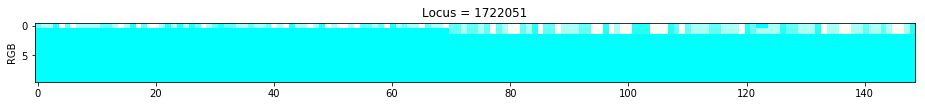

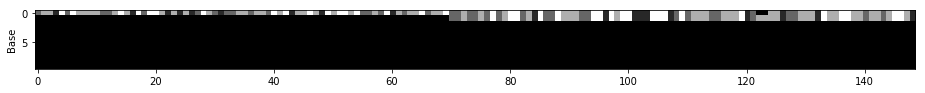

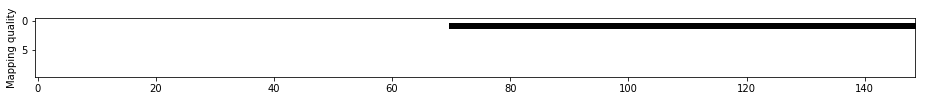

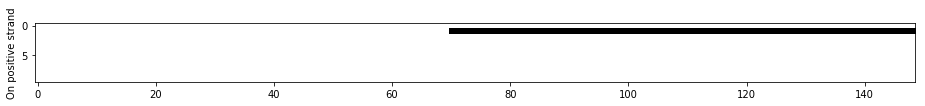

In [39]:
locus = 1722051
visualization_locus(locus, FINAL_RGB)

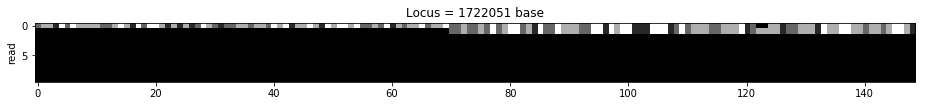

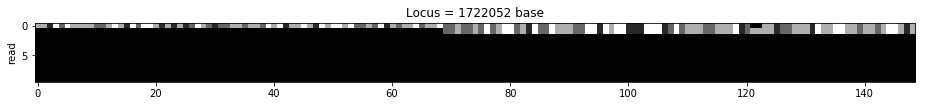

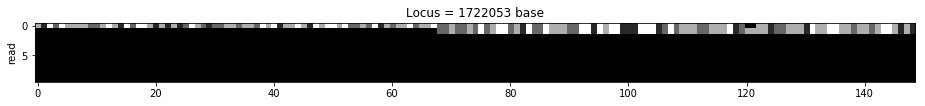

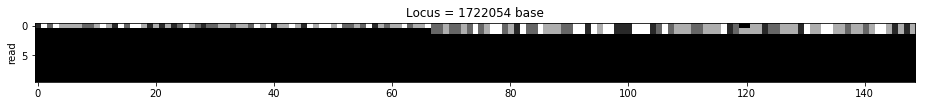

In [86]:
# base or mapping_quality or on_positive_strand
locus = 1722051
channel = "base"
visualization_sequential_four(locus, FINAL_RGB, channel)

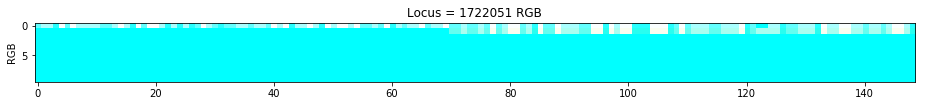

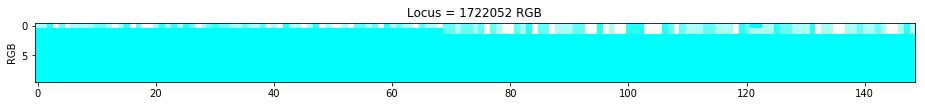

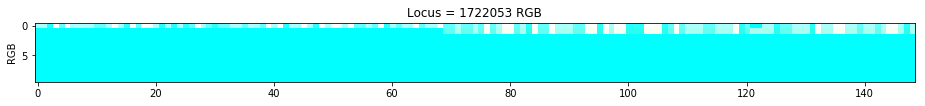

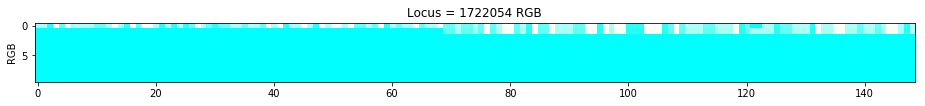

In [88]:
locus = 1722051
visualization_sequential_four_RGB(locus, FINAL_RGB)